In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# preprocess
from sklearn.compose import ColumnTransformer

# pipline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import  SMOTE

# Set up nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize

# Visual the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# MODEL
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
import time
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load dataset

In [ ]:
review_data = pd.read_csv('../Clean_data/clean_review_data.csv')
review_data.head()

,IDRestaurant,date_time,user_id,rating_scaler,clean_review,sentiment_encode,rating_encode,label
0,1,2023-12-20 21:13:00,8670,5.68,gà chiên còn sống rất,0.0,2.0,2.0
1,1,2023-09-25 15:43:00,11063,5.50,đã ăn ăn đồng_ý,0.0,2.0,2.0
2,1,2023-06-24 11:11:00,9541,5.50,đã thư rất ngon,1.0,2.0,2.0
3,1,2022-12-22 14:58:00,9112,1.90,về gói thêm khách ơ lại ăn về lại phải thêm ph...,0.0,0.0,0.0
4,1,2022-09-23 22:40:00,9651,4.78,nhỏ kêu đói hồi bình_loạn là đang háo_hức vừa ...,0.0,2.0,2.0


# EDA data:

## Remove na values

In [ ]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29958 entries, 0 to 29957
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IDRestaurant      29958 non-null  int64  
 1   date_time         29958 non-null  object 
 2   user_id           29958 non-null  int64  
 3   rating_scaler     29958 non-null  float64
 4   clean_review      29848 non-null  object 
 5   sentiment_encode  29958 non-null  float64
 6   rating_encode     29958 non-null  float64
 7   label             29958 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
review_data.isna().sum()

IDRestaurant          0
date_time             0
user_id               0
rating_scaler         0
clean_review        110
sentiment_encode      0
rating_encode         0
label                 0
dtype: int64

In [ ]:
review_data.isnull().sum()

IDRestaurant          0
date_time             0
user_id               0
rating_scaler         0
clean_review        110
sentiment_encode      0
rating_encode         0
label                 0
dtype: int64

In [ ]:
clean_review_df = review_data.dropna(subset=['clean_review']).reset_index(drop=True)

## Distribution of Label

In [ ]:
clean_review_df.value_counts(subset=['label'],normalize=True)

label
1.0      0.557759
2.0      0.368869
0.0      0.073372
Name: proportion, dtype: float64

- There is a imbalance data, can apply SMOTE to make it more balance

### Show top 5 restaurant in each label

In [ ]:
count_user_by_res_label = (clean_review_df.groupby(['IDRestaurant','label'],as_index=False)
                           .agg({'user_id':'count'})
                           .rename(columns={'user_id':'count_user'})
                           .sort_values(by=['label','count_user'],ascending=False))
count_user_by_res_label['label'] = count_user_by_res_label['label'].replace({0:'negative',1:'positive',2:'neutral'})

In [ ]:
top_5_restaurant = count_user_by_res_label.groupby(['label'])['count_user'].nlargest(5).reset_index()
top_5_restaurant.columns = ['label', 'restaurant_id','count_user']

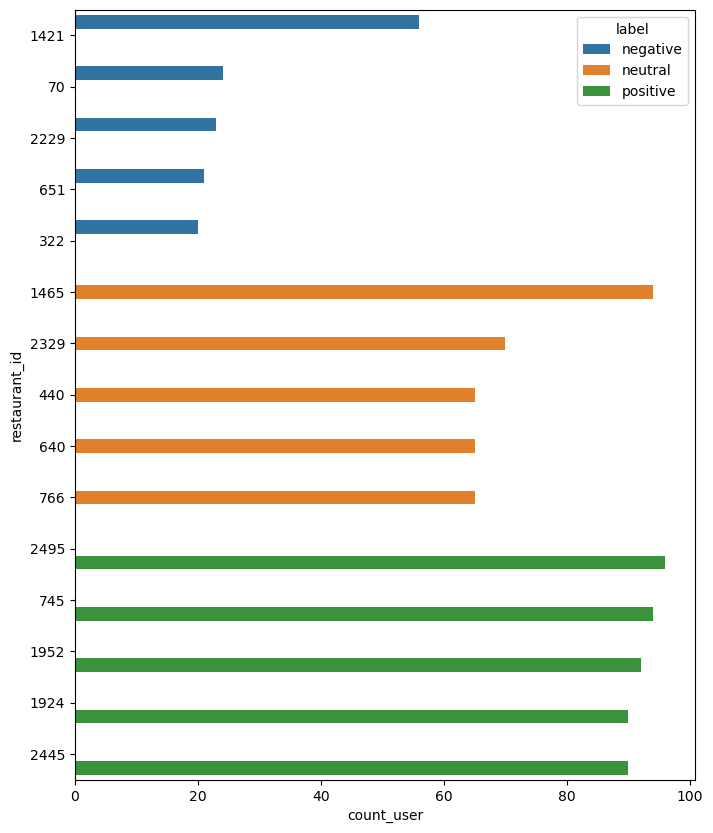

In [ ]:
order_h = top_5_restaurant['restaurant_id'].values
plt.figure(figsize=(8,10))
sns.barplot(data=top_5_restaurant,x='count_user',y='restaurant_id',hue='label',orient='h',order=order_h)
plt.show()

# Data Splitting and Preprocessing

In [ ]:
X = clean_review_df[['clean_review']]
y = clean_review_df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [ ]:
with open('../DATA_shopeefood/files/vietnamese-stopwords.txt', 'r', encoding="utf8") as file:
    stop_words = file.read().split('\n')

In [ ]:

lemma = WordNetLemmatizer()

def pre_process(text):

    ## tokenize => slpit words into list by space
    tokenized = word_tokenize(text)

    ## stopwords removal
    stw = [word for word in tokenized if word not in stop_words]

    ## lower
    lower = [word.lower() for word in stw]

    ## lemma
    result=[lemma.lemmatize(word) for word in lower]

    #### join to make a sentence
    results = " ".join(result)

    return results

In [ ]:
# preprocess data
tqdm.pandas(desc='Preprocess Text in Train data')
X_train_pre = X_train.progress_apply(lambda x: pre_process(x['clean_review']),axis=1)

tqdm.pandas(desc='Preprocess Text in Test Data')
X_test_pre = X_test.apply(lambda x: pre_process(x['clean_review']),axis=1)

# remove some specific digit
X_train_pre =(X_train_pre
              .str.replace(pat=r'[@:\(\)\-!=?\.\\,]',regex=True,repl='')
              .str.replace(pat='from',repl='')
              .str.replace(pat=r'\s+',repl=' ',regex=True))

X_test_pre =(X_test_pre
             .str.replace(pat=r'[@:\(\)\-!=?\.\\,]',regex=True,repl='')
             .str.replace(pat='from',repl='')
             .str.replace(pat=r'\s+',repl=' ',regex=True))

Preprocess Text in Train data:   0%|          | 0/20893 [00:00<?, ?it/s]

# Build and Evaluate Model

## Build model

### TF-IDF Vectorizer and MultinomialNB

In [ ]:
# create TF IDF naive bayes model
tf_idf_nb_clf = Pipeline(steps=[
    ("tf_idf",TfidfVectorizer(stop_words=stop_words)),
    ('oversampling', SMOTE(random_state=42)),
    ("naive", MultinomialNB())
])
tf_idf_nb_clf.fit(X_train_pre,y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words=['a_lô', 'a_ha', 'ai', 'ai_ai',
                                             'ai_nấy', 'ai_đó', 'alô', 'amen',
                                             'anh', 'anh_ấy', 'ba', 'ba_ba',
                                             'ba_bản', 'ba_cùng', 'ba_họ',
                                             'ba_ngày', 'ba_ngôi', 'ba_tăng',
                                             'bao_giờ', 'bao_lâu', 'bao_nhiêu',
                                             'bao_nả', 'bay_biến', 'biết',
                                             'biết_bao', 'biết_bao_nhiêu',
                                             'biết_chắc', 'biết_chừng_nào',
                                             'biết_mình', 'biết_mấy', ...])),
                ('oversampling', SMOTE(random_state=42)),
                ('naive', MultinomialNB())])

In [ ]:
print("Train accuracy of TFIDF Vectorizer:\n",tf_idf_nb_clf.score(X_train_pre,y_train))

Train accuracy of TFIDF Vectorizer:
 0.8142440051691954


In [ ]:
print("Test accuracy of Count Vectorizer:\n",tf_idf_nb_clf.score(X_test_pre,y_test))

Test accuracy of Count Vectorizer:
 0.68285873813512


### Count Vectorizer and MultinomialNB

In [ ]:
%%time
# create Count naive bayes model
count_nb_clf = Pipeline(steps=[
    ("count_vector",CountVectorizer(stop_words=stop_words)),
    ('oversampling', SMOTE(random_state=42)),
    ("naive", MultinomialNB())
])
count_nb_clf.fit(X_train_pre,y_train)

CPU times: total: 2.02 s
Wall time: 3.49 s


Pipeline(steps=[('count_vector', CountVectorizer(stop_words='english')),
                ('oversampling', SMOTE(random_state=42)),
                ('naive', MultinomialNB())])

Train accuracy of Count Vectorizer:
 0.8115636816158522


In [ ]:
print("Train accuracy of Count Vectorizer:\n",count_nb_clf.score(X_train_pre,y_train),'\n')
print("Train accuracy of Count Vectorizer:\n",count_nb_clf.score(X_test_pre,y_test))

Train accuracy of Count Vectorizer:
 0.8115636816158522 

Train accuracy of Count Vectorizer:
 0.6929089893914014


### Random Forest

In [ ]:
%%time
tf_idf_rf_model = Pipeline(steps=[
    ("tf_idf",TfidfVectorizer(stop_words=stop_words)),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,n_jobs=-1))
])
tf_idf_rf_model.fit(X_train_pre,y_train)

CPU times: total: 6min 49s
Wall time: 30.1 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words=['a_lô', 'a_ha', 'ai', 'ai_ai',
                                             'ai_nấy', 'ai_đó', 'alô', 'amen',
                                             'anh', 'anh_ấy', 'ba', 'ba_ba',
                                             'ba_bản', 'ba_cùng', 'ba_họ',
                                             'ba_ngày', 'ba_ngôi', 'ba_tăng',
                                             'bao_giờ', 'bao_lâu', 'bao_nhiêu',
                                             'bao_nả', 'bay_biến', 'biết',
                                             'biết_bao', 'biết_bao_nhiêu',
                                             'biết_chắc', 'biết_chừng_nào',
                                             'biết_mình', 'biết_mấy', ...])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:
print("Train accuracy of RandomForest:\n",tf_idf_rf_model.score(X_train_pre,y_train),'\n')
print("Train accuracy of RandomForest:\n",tf_idf_rf_model.score(X_test_pre,y_test))

Train accuracy of RandomForest:
 0.986263341789116 

Train accuracy of RandomForest:
 0.7009491903964266


- Decision Tree

In [ ]:
%%time
tf_idf_dt_model = Pipeline(steps=[
    ("tf_idf",TfidfVectorizer(stop_words=stop_words)),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])
tf_idf_dt_model.fit(X_train_pre,y_train)

CPU times: total: 54.9 s
Wall time: 24.2 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(stop_words=['a_lô', 'a_ha', 'ai', 'ai_ai',
                                             'ai_nấy', 'ai_đó', 'alô', 'amen',
                                             'anh', 'anh_ấy', 'ba', 'ba_ba',
                                             'ba_bản', 'ba_cùng', 'ba_họ',
                                             'ba_ngày', 'ba_ngôi', 'ba_tăng',
                                             'bao_giờ', 'bao_lâu', 'bao_nhiêu',
                                             'bao_nả', 'bay_biến', 'biết',
                                             'biết_bao', 'biết_bao_nhiêu',
                                             'biết_chắc', 'biết_chừng_nào',
                                             'biết_mình', 'biết_mấy', ...])),
                ('oversampling', SMOTE(random_state=42)),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [ ]:
print("Train accuracy of Decesion Tree:\n",tf_idf_dt_model.score(X_train_pre,y_train),'\n')
print("Train accuracy of Decesion Tree:\n",tf_idf_dt_model.score(X_test_pre,y_test))

Train accuracy of Decesion Tree:
 0.986263341789116 

Train accuracy of Decesion Tree:
 0.621998883305416


# Evaluate the model

## TF-IDF

In [ ]:
list_model = [tf_idf_nb_clf,
              count_nb_clf,
              tf_idf_dt_model,
              tf_idf_rf_model]

In [ ]:
' -- '.join([i[0].upper() for i in tf_idf_nb_clf.steps])

'TF_IDF -- OVERSAMPLING -- NAIVE'

In [ ]:
for m in list_model:
    name_model = ' -- '.join([i[0].upper() for i in m.steps])
    print(f'*** {name_model}***')
    # Set timer
    start = time.time()
    cv = 10
    # evaluate model
    score1 = cross_val_score(m, X_test_pre, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
    score2 = cross_val_score(m, X_test_pre, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
    score3 = cross_val_score(m, X_test_pre, y_test, scoring='f1_micro', cv=cv, n_jobs=-1)
    # summarize performance
    print('Mean ROC AUC: %.3f' % np.mean(score1))
    print('Mean Accuracy score: %.3f' % np.mean(score2))
    print('Mean F1 score: %.3f' % np.mean(score3))

    # Classification report
    y_test_tfidf_prd = m.predict(X_test_pre)
    print(classification_report(y_test,y_test_tfidf_prd))
    end = time.time()
    print(f'\nTime in Evaluating {name_model}: {round((end-start)/60,2)} min\n\n')

*** TF_IDF -- OVERSAMPLING -- NAIVE***
Mean ROC AUC: 0.816
Mean Accuracy score: 0.674
Mean F1 score: 0.674
              precision    recall  f1-score   support

         0.0       0.45      0.58      0.51       657
         1.0       0.74      0.88      0.80      4995
         2.0       0.63      0.40      0.49      3303

    accuracy                           0.68      8955
   macro avg       0.60      0.62      0.60      8955
weighted avg       0.67      0.68      0.67      8955


Time in Evaluating TF_IDF -- OVERSAMPLING -- NAIVE: 0.39 min


*** COUNT_VECTOR -- OVERSAMPLING -- NAIVE***
Mean ROC AUC: 0.813
Mean Accuracy score: 0.693
Mean F1 score: 0.693
              precision    recall  f1-score   support

         0.0       0.44      0.51      0.47       657
         1.0       0.76      0.87      0.81      4995
         2.0       0.63      0.47      0.53      3303

    accuracy                           0.69      8955
   macro avg       0.61      0.61      0.60      8955
weighted 

## Try to Use AdaBoost to see better result

In [ ]:
print('*** APPLY ADA BOOST ***')
# Set timer
start = time.time()
print("Start time:", time.asctime(time.localtime(start)))

# Build Ada boost model
clf_adb_model = Pipeline(steps=[
    ("tf_idf",TfidfVectorizer(stop_words=stop_words)),
    ('oversampling', SMOTE(random_state=42)),
    ('clf', AdaBoostClassifier(random_state=42,algorithm='SAMME.R'))
])

# Fit model
clf_adb_model.fit(X_train_pre,y_train)

# Cross validation
cv = 5
# evaluate model
score1 = cross_val_score(clf_adb_model, X_test_pre, y_test, scoring='roc_auc_ovr', cv=cv, n_jobs=-1,error_score='raise')
score2 = cross_val_score(clf_adb_model, X_test_pre, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
score3 = cross_val_score(clf_adb_model, X_test_pre, y_test, scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(score1))
print('Mean Accuracy score: %.3f' % np.mean(score2))
print('Mean F1 score: %.3f \n' % np.mean(score3))
# Classification report
y_test_prd = clf_adb_model.predict(X_test_pre)
print(classification_report(y_test, y_test_prd))
end = time.time()
print(f'\nTime in running training model: {round((end-start)/60,2)} min\n\n')

*** APPLY ADA BOOST ***
Start time: Sat Mar  9 02:57:53 2024
Mean ROC AUC: 0.704
Mean Accuracy score: 0.653
Mean F1 score: 0.586 

              precision    recall  f1-score   support

         0.0       0.33      0.74      0.45       657
         1.0       0.75      0.78      0.77      4995
         2.0       0.55      0.38      0.45      3303

    accuracy                           0.63      8955
   macro avg       0.54      0.63      0.56      8955
weighted avg       0.65      0.63      0.63      8955


Time in running training model: 0.81 min




**Comment**:

After evaluating 5 models, I have some following thought:

Regards of the executive time, as can be seen above report, this is a order from the fastest model to the lowest one  
1. ***COUNT_VECTOR -- OVERSAMPLING -- NAIVE*** : 0.07 min
2. TF_IDF -- OVERSAMPLING -- NAIVE             : 0.39 min
3. TF_IDF -- OVERSAMPLING -- Decision Tree     : 0.68 min
4. TF_IDF -- OVERSAMPLING -- ADABOOST          : 0.81 min
5. TF_IDF -- OVERSAMPLING -- RANDOM FOREST     : 0.81 min

However if we focus on performance, there is a slightly difference in term of sequence but top 1 is still : (F1 score)
1. ***COUNT_VECTOR -- OVERSAMPLING -- NAIVE*** :  0.693
2. TF_IDF -- OVERSAMPLING -- RANDOM FOREST     : 0.687
3. TF_IDF -- OVERSAMPLING -- NAIVE             : 0.674
4. TF_IDF -- OVERSAMPLING -- Decision Tree     : 0.607
5. TF_IDF -- OVERSAMPLING -- ADABOOST          : 0.586

=>> Use this model to predict if a random comment is positive or negative or neutral

# Save model:

In [ ]:
import pickle

In [ ]:
with open('../Clean_data/predict_review_model.pkl', 'wb') as file:
    pickle.dump(count_nb_clf, file)